### 머신러닝
- 데이터를 기반으로 학습
- 과거 컴퓨터로 데이터 입력, 특징과 학습 패턴을 찾는 패턴 인식

#### 식에 필요한 요소
- 무언가(x)로 무엇(y)를 예측하고 싶다.

    $$ f(x) = y $$

    - x : 독립변수(입력변수)x
    - y : 종속변수(출력변수)
    - f : 머신러닝 모형(모델)

- 우리는 이때까지 f를 직접 코딩했음. x값들을 입력하면 y가 나오도록 개발
- 머신러닝/딥러닝 x, y를 다 입력해서 훈련을 시켜 함수 f를 컴퓨터가 만들도록 하는 것

#### 데이터셋 분리
- 훈련을 시켜서 독립변수에 대한 종속변수가 도출되는 모델 만들 수 있음
- 100% 훈련에 사용하면 검증을 할 데이터가 없음
- Train 데이터로 훈련 후 Test 데이터로 실험. 또는 Train 데이터로 훈련, Valid 데이터 검증 후, Test 데이터 실험

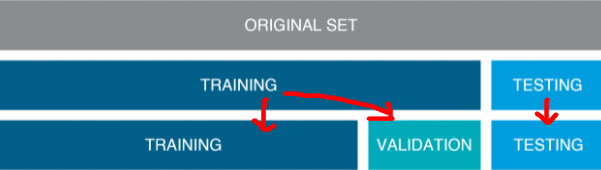

- 100%에서 Train과 Test를 나눌 때 7:3 또는 8:2로 비율을 나눔

##### 사이킷런으로 타이타닉 생존자 예측

- 선형회귀 : 선형회귀에 대한 정의는 결론을 본 뒤 설명
- 사이킷런 설치
```python
    !pip install scikit-learn
```

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install tqdm
!pip install scikit-learn

In [2]:
# 분석, 시각화 라이브러리 사용/ 없으면 알아서 설치!!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc, font_manager
import warnings
import seaborn as sns
import time
from tqdm import tqdm  # 반복 진행 프로그레스바 모듈

In [15]:
## 영문으로 차트 사용시 설정
warnings.simplefilter('ignore') # 경고메시지 출력숨김

plt.rcParams['font.size'] = 12 # 글자크기
plt.rcParams['figure.figsize'] = (12, 4) # (W, H)
plt.rcParams['axes.grid'] = True # 차트 가로세로줄 표시

## 시본 설정
sns.set_theme(style='darkgrid', color_codes=True)

In [14]:
## Seaborn 팔레트 설정용 함수
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

- https://github.com/datasciencedojo/datasets/blob/master/titanic.csv 에서 통합 데이터 다운로드

In [37]:
## 사이킷런 임포트
from sklearn import preprocessing

##### 데이터로드
- 캐글 사이트에서 다운로드
- https://www.kaggle.com/competitions/titanic/data

- Seaborn 데이터 로드 기능(샘플 데이터가 20개 가량 존재 -> 타이타닉 데이터 포함)

In [3]:
## 타이타닉 훈련데이터
df_train = pd.read_csv('./data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
## Seaborn에서 데이터 로드 -> 891개 데이터만 존재, 불필요한 중복 컬럼이 많음 -> 전처리하여 사용
## https://github.com/mwaskom/seaborn-data 나머지 데이터 셋 정보
df_titanic = sns.load_dataset('titanic')
df_titanic.head()

- 데이터 컬럼 정의
    1. PassangerId : 탑승자 데이터 일련번호
    2. Survived : 생존여부 0사망 1생존
    3. Pclass : 티켓의 선실 등급 1:일등석실, 2:이등석실, 3:삼등석실
    4. Name : 탑승자명
    5. Sex : 성명 male:남성 female:여성
    6. Age : 나이
    7. SibSp: Sibling(형제), Spouse(배우자) 동반 형제와 배우자 수
    8. Patch: Parent, Child 동반한 부모 또는 자녀 인원수
    9. Ticket : 티켓번호
    10. Fare : 티켓요금
    11. Cabin: 선실번호
    12. Embarked: 탑승 항구 코드 C.herbourg, Q.ueenstown, S.outhhampton

In [ ]:
df_train.info()

- 데이터
    - 총 891개, 12개 컬럼, 2개의 float64,5개의 object(=string), 5개의 int64
- 결측치(Null값)
    - Age 177개
    - Cabin 687개
    - Embarked 2개

##### 데이터 전처리

- Age의 결측치 - 나이의 빈 값은 평균치 입력
- Cabin의 결측치 - 2등석, 3등석 결측치 분포. 재검토
- Embarked의 결측치 - 탑승항구가 세 군데, 그중에 가장 많이 탄 곳에서 탔을거다!

In [18]:
# Age의 결측치
## 나이의 평균은 29.6923834 => 30.0
# round(df_train['Age'].mean())
df_train['Age'].fillna(round(df_train['Age'].mean()), inplace=True)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# NaN: Not a Number
df_train[df_train['Embarked'].isna()] # 61, 829

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [17]:
## Embarked
## value_counts() 결과는 max부터 내림차순으로 나오기때문에 
# df_train['Embarked'].value_counts().max()
# df_train['Embarked'].value_counts().index[0] # S
df_train['Embarked'].fillna(df_train['Embarked'].value_counts().index[0], inplace=True)

In [8]:
## 해당 인덱스 값만 추출
df_train.loc[[61, 829]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


In [9]:
## Cabin 결측치는 컬럼을 삭제
df_train['Cabin'] 

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [10]:
# axis - 0행삭제, 1열삭제, inplace - 교체여부
df_train.drop(['Cabin'], axis=1, inplace=True)

In [11]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.0,1,2,W./C. 6607,23.45,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,Q


##### 차트 시각화

In [12]:
## 성별, 생존자수 파악
df_train.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

- ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'] ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

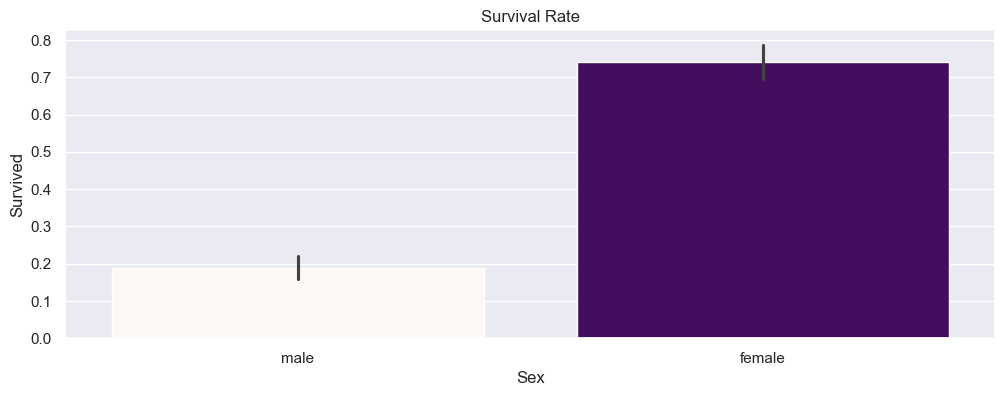

In [16]:
## Seaborn으로 시각화
sns.barplot(data=df_train, x='Sex', y='Survived', palette=colors_from_values(df_train['Survived'], 'RdPu'))
plt.title('Survival Rate')
plt.show()

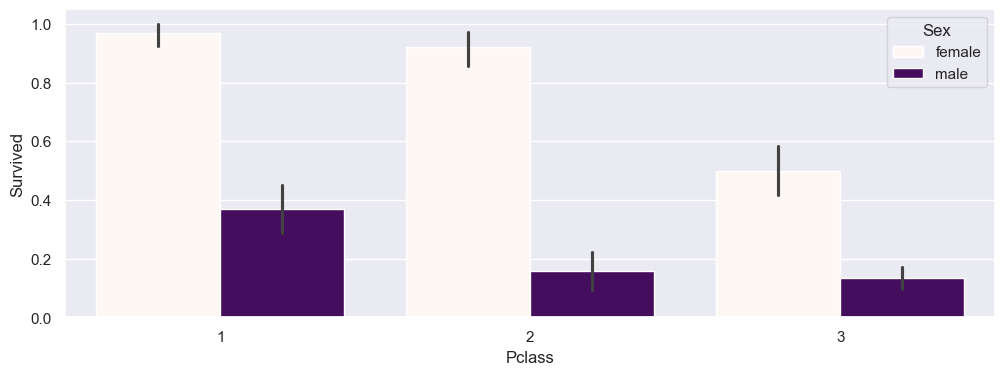

In [19]:
sns.barplot(data=df_train, x='Pclass', y='Survived', hue='Sex', palette=colors_from_values(df_train['Survived'], 'RdPu'))
plt.show()

In [ ]:
df_train['Age'].value_counts()

In [20]:
## 연령대 도출 함수
def get_ageGroup(age):
    cate = ''
    # if age <= -1: cate = 'Unknown'
    if age <= 5: cate = 'Baby'
    elif age <= 12: cate = 'Child'
    elif age <= 18: cate = 'Teenager'
    elif age <= 25: cate = 'Student'
    elif age <= 35: cate = 'Young Adult'
    elif age <= 60: cate = 'Adult'
    else: cate = 'Elderly'

    return cate

In [21]:
group_name = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

In [22]:
df_train['AgeGroup'] = df_train['Age'].apply(lambda x: get_ageGroup(x))

In [23]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult


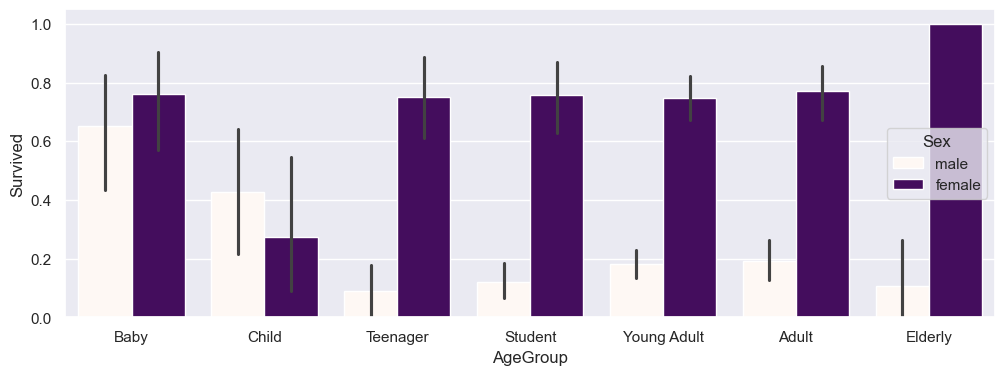

In [24]:
## 연령대로 바차트
sns.barplot(data=df_train, x='AgeGroup', y='Survived', hue='Sex', palette=colors_from_values(df_train['Survived'], 'RdPu'), order=group_name)
plt.show()

##### 문자열을 숫자로
- 문자(열)로 된 컬럼(Name, Ticket), 카테고리 컬럼(Sex, Embarked) 중 카테고리는 문자를 숫자로 변환가능
- 사이킷런 LabelEncorder 클래스 사용

In [38]:
def encode_features(df):
    features = ['Sex', 'Embarked']
    for feat in features: # 두개의 컬럼을 반복해서
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feat]) # Sex, Embarked 컬럼값을 입력받아서 자동으로 카테고리 숫자화
        df[feat] = le.transform(df[feat]) # 기존값과 카테코리숫자를 비교해서 숫자로 변경

    return df

In [26]:
# 이전값 확인
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult


In [39]:
df_train = encode_features(df_train)

In [40]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,Adult
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,Young Adult
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2,Young Adult


##### 머신러닝으로 생존자 예측

- 독립변수(x) - 입력값 와 종속변수(y) - 정답으로 분리
- 독립변수 - Survived를 뺀 나머지. 훈련에 의미가 없을 컬럼(변수)도 삭제
- 종속변수 - Survived(생존여부)
- PassengerID와 같은 의미없는 변수를 추가하면 정확도가 떨어짐

In [41]:
## 종속변수 추출
y_df_titanic = df_train['Survived']
y_df_titanic.shape # 시리즈

(891,)

In [42]:
## 독립변수 추출
X_df_titanic = df_train.drop(['PassengerId', 'Name', 'Ticket', 'AgeGroup', 'Survived'], axis=1)
X_df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int32  
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 41.9 KB


In [43]:
## 데이터분리 891
## 기존 캐글 데이터는 훈련용 891, 실험용 418 개 따로 분리
## Seaborn 등에서는 891개의 데이터를 7:3으로 Train:Test 분리 작업을 해왔음
## 만약에 train_test_split 이 없으면
### 개발자가, DF 랜덤값으로 섞어주고, 판다스로 나누고, 독립변수, 종속변수 판다스 나누고
### 변수에 다 지정해줘야 함(엄청 시간이 많이걸리고 귀찮음)
from sklearn.model_selection import train_test_split

In [44]:
## 초기에 모두 섞은다음, 일치하는 독립변수와 종속변수를 알아서 해당변수에 입력해줌
## random_state는 본인마음. 0 ~ 41 사이의 숫자를 지정하면 됨
X_train, X_test, y_train, y_test = train_test_split(X_df_titanic, y_df_titanic, test_size=0.2, random_state=13)

In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 711 to 338
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    int32  
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  712 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 38.9 KB


In [46]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 712 entries, 711 to 338
Series name: Survived
Non-Null Count  Dtype
--------------  -----
712 non-null    int64
dtypes: int64(1)
memory usage: 11.1 KB


In [47]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 736 to 815
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    179 non-null    int64  
 1   Sex       179 non-null    int32  
 2   Age       179 non-null    float64
 3   SibSp     179 non-null    int64  
 4   Parch     179 non-null    int64  
 5   Fare      179 non-null    float64
 6   Embarked  179 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 9.8 KB


In [48]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 179 entries, 736 to 815
Series name: Survived
Non-Null Count  Dtype
--------------  -----
179 non-null    int64
dtypes: int64(1)
memory usage: 2.8 KB


##### 사이킷런의 머신러닝 모델

In [35]:
from sklearn.linear_model import LinearRegression ## ML 선형회귀
from sklearn.linear_model import LogisticRegression ## ML 로지스틱회귀
from sklearn.tree import DecisionTreeClassifier ## ML 결정트리
from sklearn.ensemble import RandomForestClassifier ## ML 랜덤 포레스트 분류

from sklearn.metrics import accuracy_score # 정확도 점수

In [50]:
## 선형회귀 모델 객체생성
lir_model = LinearRegression()
lir_model

LinearRegression()

In [52]:
## 훈련시작
lir_model.fit(X_train, y_train)

LinearRegression()

In [53]:
## 예측(실험) - 예측할 때는 정답을 안넣음
lir_pred = lir_model.predict(X_test)

In [54]:
## 학습하고 예측한 결과 평가
## 테스트값과 예측값을 같이 넣어서 둘 사이를 비교, 정확도 얼마나 되느닞
y_test_fl = y_test.astype('float64')

In [55]:
pd.Series(lir_pred)

0      0.434141
1      0.190769
2      0.078711
3      0.134256
4      0.109640
         ...   
174    0.008678
175    0.874452
176    0.441953
177    0.754278
178    0.425226
Length: 179, dtype: float64

In [56]:
accuracy_score(y_true=y_test_fl, y_pred=lir_pred)
## 생존자 예측은 0/1 두개로 나뉨(분류)
## 분류에는 선형회귀 할 수 없음
## Classification metrics can't handle a mix of binary and continuous targets

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [57]:
## 로지스틱 회귀 모델 생성
lgr_model = LogisticRegression()
lgr_model

LogisticRegression()

In [58]:
## 훈련시작
lgr_model.fit(X_train, y_train)

LogisticRegression()

In [59]:
## 예측
lgr_pred = lgr_model.predict(X_test)

In [60]:
### 로지스틱 회귀 예측값 평가
print(f'로지스틱회귀 정확도 = {accuracy_score(y_true=y_test, y_pred=lgr_pred)}') 

로지스틱회귀 정확도 = 0.8324022346368715


In [61]:
y_pred = pd.DataFrame(lgr_pred)
y_pred.tail()

,0
174,0
175,1
176,0
177,1
178,0


#### ruffhs
- 머신러인 기본에 회귀
- 측정된 값들로 규칙을 찾아내는 것

- 선형회귀:측정값을 참조하면 직선의 함수가 도출됨
    - 선형회귀는 1차 방정식
    
<img src="https://upload.wikimedia.org/wikipedia/commons/b/be/Normdist_regression.png?20080104184121" width="700">

- 로지스틱회귀:종속변수가 두개의 클래스로 가지는 범주형일때 분류 기법으로 사용하는 회귀
    - 로지스틱회귀는 시그모이드 함수

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/480px-Logistic-curve.svg.png" width="700" style="background:white">

#### 파이토치로 생존자 예측

- 딥러닝을 사용해서 생존자 예측

In [28]:
## 파이토치 진행 
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [ ]:
## train과 test 데이터를 df_train, df_test
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [ ]:
df_train.info()

In [ ]:
df_train.tail()

In [ ]:
df_test.tail()

##### 데이터 전처리
- 불필요한 변수 삭제 - Name, Ticket, Cabin 삭제

In [ ]:
df_train.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)
df_test.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)

In [ ]:
df_train.tail()

In [ ]:
df_test.tail()

- 결측치 처리
    - 나이, 선임의 NaN을 채워야함

In [ ]:
df_test.info()

In [ ]:
df_test.info()

In [ ]:
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

# df_train['Embarked'].fillna(df_train['Embarked'].value_counts().index[0], inplace=True)
# df_test['Embarked'].fillna(df_test['Embarked'].value_counts().index[0], inplace=True)


##### 파이토치 학습 모델

- 신경망 생성

    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Neural_network_example.svg/330px-Neural_network_example.svg.png" style="background:white" width="200">

- 신경망, 사람의 뇌의 뉴런과 유사하게 네트워크 구성
    - 입력층(input layer), 은닉층(hidden layer), 출력층(output layer)
    - 은닉층이 하나지만, 실제로 딥러닝 할 때 은닉층을 여러층으로 나눠서 반복 학습을 실행
    - 은닉층이 많아지면 처리속도가 급감, 이때 활용하는 것이 GPU(CUDA)

- 모델링
    - 활성화 함수 : 입력을 변환하는 함수
        - Sign 함수
        - Sigmoid 함수
        - Tanh 함수
        - Softmax 함수
        - ReLU(Recified Linear Unit)함수 - 로지스틱 회귀에 썻던 시그모이드보다 오차(경사사라짐)가 줄어들게 만들수 있는 활성화함수로 개발

        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/ReLU_and_Nonnegative_Soft_Thresholding_Functions.svg/1920px-ReLU_and_Nonnegative_Soft_Thresholding_Functions.svg.png" width="700" style="background:white">
        
        - Leaky ReLU 함수

In [ ]:
## 은닉층 2개, 2개 뉴런을 가지는 출력층 1개
class NeuralNet(nn.Module): # mm.Module이 부모클래스
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hlayer1 = nn.Sequential(
            nn.Linear(8, 512), ## 8개의 입력을 512개로 분산(경우의 수를 늘리는 것)
            nn.ReLU(), ## 할성화 함수,
            nn.Dropout(0.2) ## Overfitting 방지
        )

        self.hlayer2 = nn.Sequential(
            nn.Linear(512, 512), ## hlayer1의 출력이 512니까 입력도 512개 되어야함
            nn.LeakyReLU(), ## 활성화 함수를 위에 Sin 이외 것들은 다 사용할 수 있음
            nn.Dropout(0.2)
        )

        self.olayer = nn.Linear(512, 2)

    def forward(self, x):
        x = self.hlayer1(x)
        x = self.hlayer2(x)
        x = self.olayer(x)
        return x

##### 스케일러
- 원본 데이터는 영향을 크게 미치는 변수(feature와 영향을 미치지 못한느 변수 > 패턴 착기 어렵고, 합습 능력도 저하)
- 표준 스케일러(StandardScalar)를 사용, 데이터를 스케일링
- 기준 변수의 범위를 정규분포로 변환

In [ ]:
df_train.tail()

In [ ]:
## 종속변수(y) : Survived 추출
## Ndarray(넘파이 배열)
y_train = df_train['Survived'].values

In [ ]:
## 훈련 데이터의 고객번호
sub_train_PassengerId = df_train['PassengerId'].values

In [ ]:
## 스케일링 시작
Scalar_train = StandardScaler()
Scalar_test = StandardScaler()

In [ ]:
df_train_new = df_train.drop(['Survived'],axis = 1)
# df_test_new = df_test.drop(['Survived'],axis = 1)

In [ ]:
df_train_new.tail()

In [ ]:
## 8개의 독립변수를 정규분포
df_train_last = pd.DataFrame(Scalar_train.fit_transform(df_train_new))
df_test_last = pd.DataFrame(Scalar_test.fit_transform(df_test_new))

In [ ]:
df_column_names = df_train.drop(['Survived'], axis=1).columns

In [ ]:
## 정규분포화 되면서 사라진 컬럼명을 다시 할당
df_train_last.columns = df_column_names
df_test_last.columns = df_column_names

In [ ]:
df_test_last.tail()

In [ ]:
### df_train_last 값들을 독립변수 훈련 데이터 X_train로 담기
df_train_last.values

##### 데이터 로더
- 데이터를 좀 더 쉽게 다룰 수 있도록 데이터로더 객체 만들기
- 기존 값을 데이터셋으로 만들고, 데이터로더로 생성

In [ ]:
### df_train_last 값들을 독립변수 훈련 데이터 X_train로 담기
X_train = df_train_last.values

In [ ]:
X_train = torch.FloatTensor(x_train) # 기존 소수점 8자리 값을 소수점 4자리 값으로 형변환

y_train = torch.FloatTensor(y_train) # 기존의 0, 1정수를 0.0, 1.0의 실수로 형 변환 

In [ ]:
dataset = TensorDataset(X_train, y_train)

In [149]:
dataset

NameError: name 'dataset' is not defined

In [ ]:
dataloader = DataLoader(dataset = dataset, batch_size=64, shuffle=True)

- batch_size, shuffle, 은닉층 생성시 출력 뉴런갯수 등... 사용자으 ㅣ개입이 필요한 임의 변수값 -> 하이퍼 파라미터

In [ ]:
dataloader

##### 손실함수, 최적화
- 손실함수(Loss Function) - 머신러닝/딥러닝 모델의 출력값과 사용자가 원하는 출력값 사이의 오차
- 점수가 높을 수록 좋지 않은 모델 판별
- 손실 함수의 함수 값이 최소화가 되도록하는 가중치(weight)와 편향(bias)를 찾는 것이 목표

- 손실함수 종료
    - MSE(Mean Squared Error) : 평균 제곱 오차
    - RMSE(Root Mean Squared Error) : 루트 평균 제곱 오차, MSE에 루트 씌운 것
    - Binary CrossEntropy : 이진 교차 엔트로피
    - Categorical CrossEntropy : 카테고리화 교차 엔트로피
    - Focal loss : 

- 손실함수 수식 외우는 것이 아닌, 어떤 것을 사용했을 때 예측률이 높아지느냐에 중점

- 손실함수, 목적함수, 비용함수
    - 목적함수, 비용함수는 같은 의미
    - 비용함수는 손실함수를 사용하여 정의 가능

- 최적화 알고리즘 - 뉴럴 네트워크를 빠르게 훈련시키는 알고리즘
- 딥러닝은 크기가 큰 데이터의 경우 잘 작동, 데이터 크기가 클수록 훈련 속도가 느려짐
- 가중치와 평향, Learning Rate(학습률) 값을 사용
- 최적화 알고리즘 종료
    - Gradient Descent
        - 배치 경사 하강
        - 최소배치 경사 하강
        - 통계적 경사 하강(V)
    - Mementum
    - RMSprop
    - Adam(Adaptive Moment Estimation) - Momentum + RMSprop -> 가장 좋은 결과를 나타냄. 현재 딥러닝에 가장 흔하게 사용

In [ ]:
## 손실함수 -> 크로스엔트로피 사용
criterion = nn.CrossEntropyLoss()

## 최적화 알고리즘 -> Adam
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.01)

##### Training
- epoch : 반복수

In [ ]:
nb_epochs = 500
train_loss_min = np.Inf # 무한대

for epoch in range(nb_epochs): ## 500번 훈련 반복
    num_right = 0
    train_loss = 0

    for batch_idx, samples in enumerate(dataloader): ## 독립변수, 종속변수로 만든 데이터로더
        x_tr, y_tr = samples

        pred = nn_model(x_tr)
        loss = criterion(pred, y_tr.long()) # 예측 값과 실제 값의 오차로 나온 손실 값을 리턴

        optimizer.zero_grad()
        loss.backward() # 손실함수를 실행, PyTorch에 나오는 실행명령 backward()
        optimizer.step() ## 최적값을 찾기 위해서 한스텝 이동

        labels = torch.argmax(pred, dim=1)
        num_right += torch.sum(labels == y_tr) ## 예측과 실제값의 일치여부 합산
        train_loss += loss.item() * len(x_tr) ## 훈련 손실값 합산

    train_loss = train_loss / len(X_train)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch : {epoch + 1}/{nb_epochs}, Prediction: {num_right}/{len(X_train)}, Cost:{train_loss}')
    if train_loss <= train_loss_min:
        print(f'===== Loss decreased ({train_loss_min:6f} ==> {train_loss:6f}).Saving model =====')
        torch.save(nn_model.state_dict(), 'model.pt') ## 훈련 결과 파일 -> 나중에는 훈련시키지 않고 이 파일로 예측할 수 있음
        train_loss_min = train_loss

print('Training Terminated!!')

##### 예측처리

In [ ]:
X_test_last = torch.FloatTensor(df_test_last.values)

In [ ]:
with torch.no_grad():
    result = nn_model(X_test_last)

labels = torch.argmax(result, dim=1)
survived_result = labels.numpy()

##### 결과저장

In [ ]:
## 테스트 정보 PassangerId를 다시 생성
sub_test_PassengerId = df_test['PassangerId'].values

In [ ]:
pred_submission = pd.DataFrame({'Passanger': sub_test_PassengerId, 'Survived':survived_result})

In [ ]:
# 예측 결과 csv로 저장, 인덱스 생성은 안함
pred_submission.to_csv('./data/pred_submission', index=False)